In [1]:
from graph import *
from models import *

In [2]:
import pandas as pd

In [3]:
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import plotly.graph_objects as go

In [4]:
scaling = pd.read_excel("wall time scaling.xlsx", sheet_name="Data")

In [5]:
fit_poly = lambda x, k3, k2, k1: k3 * x ** 3 + k2 * x ** 2 + k1 * x
k, cv = curve_fit(fit_poly, scaling["Size"], scaling["Wall Time"])
k_gpu, cv_gpu = curve_fit(fit_poly, scaling["Size"], scaling["Wall Time GPU"])

In [6]:
funcs = {"Global": lambda x: fit_poly(x, *k), "Intermediate": lambda x: x / 2.0e6}
funcs_gpu = {"Global": lambda x: fit_poly(x, *k_gpu), "Intermediate": lambda x: x / 2.0e6}

In [7]:
detectors, triggers, globals = dataframes_from_spreadsheet("cms_system_200.xlsx")

In [8]:
triggers.iloc[4]["Reduction"]

53.3

In [9]:
cms_run5  = construct_graph(detectors, triggers, globals, funcs)

In [10]:
cms_run5

In [11]:
cms_run5.nodes["Intermediate"]["classifier"].ratio

53.3

In [13]:
cms_run5.nodes["Intermediate"]["classifier"].error_matrix

array([[0.91568449, 0.00125342],
       [0.06555378, 0.01750831]])

In [16]:
cms_run5.nodes["Intermediate"]["contingency"]

array([[36627380.,    50137.],
       [ 2622151.,   700332.]])

In [17]:
cms_run5.graph["op power"] / 1e6 / density_scale_model(2032)

228.08790827492982

In [19]:
total_reduction = 40e6 / 7.5e3

In [20]:
triggers

,Name,Output,Data (bytes),Reduction,Skill mean,Skill variance,Link Efficiency (J/bit),Op Efficiency (J/op),Compression
0,Tracking,Intermediate,0,1.0,0,0,2.500000e-11,0.000,0
1,Timing,Intermediate,0,1.0,0,0,2.500000e-11,0.000,0
2,Calorimetry,Intermediate,0,1.0,0,0,2.500000e-11,0.000,0
3,Muon,Intermediate,0,1.0,0,0,2.500000e-11,0.000,0
4,Intermediate,Global,260000,53.3,3,1,2.500000e-11,0.003,0
5,Global,Disk,0,100.0,4,1,2.500000e-11,16.000,0
6,Disk,NaN,0,1.0,0,0,2.500000e-11,0.000,0


In [21]:
total_reduction

5333.333333333333

In [22]:
5333 / 20

266.65

In [24]:
from metrics import *

In [43]:
def vary_l1t_accept(reduction: float):
    t = triggers.copy()
    t.at[4, "Reduction"] = reduction
    t.at[5, "Reduction"] = total_reduction / reduction
    g = construct_graph(detectors, t, globals, funcs)

    power = g.graph["op power"] + g.graph["link power"]
    r = recall(g.graph["performance"])
    #return g

    return power, r

In [44]:
g3 = vary_l1t_accept(53.3)

In [45]:
#vary_l1t_accept(53.3).graph["performance"]

In [46]:
#vary_l1t_accept(10).graph["performance"]

In [47]:
#vary_l1t_accept(1).graph["performance"]

In [48]:
res = np.array([vary_l1t_accept(r) for r in np.linspace(100, 10, 91)])

In [49]:
res.shape

(91, 2)

Text(0.5, 0, 'DAQ Power')

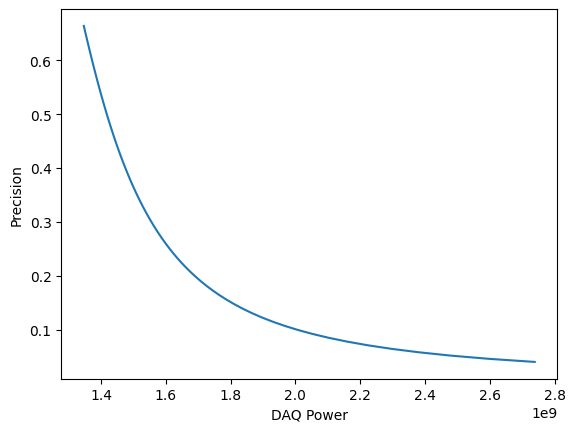

In [50]:
plt.plot(res[:,0], res[:,1])
plt.ylabel("Precision")
plt.xlabel("DAQ Power")